In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [3]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
np.random.seed(1234)

In [5]:
plt.style.use('classic')

In [6]:
import math

def intra_cluster_similarity(vectors):
    matx = scipy.sparse.vstack((vectors))
    return np.sum(cosine_similarity(matx, matx)) / math.pow(len(vectors), 2)

In [7]:
def intra_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            similarity_topics[k] = intra_cluster_similarity(values)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [8]:
def intra_cluster_weighted_similarity(vectors):
    weighted = 0.
    n = 0.
    for k, values in vectors.items():
        n += len(values)
            
    for k, values in vectors.items():
        if len(values) > 0:
            weighted += len(values) * intra_cluster_similarity(values)

    return weighted / n

In [9]:
def inter_cluster_overall_similarity2(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            matx = scipy.sparse.vstack((values))
            centroid1 = matx.sum(axis=0) / len(values)
            similarities = []
            for k2, values2 in vectors.items():
                if len(values2) > 0 & k != k2:
                    matx2 = scipy.sparse.vstack((values2))
                    centroid2 = matx2.sum(axis=0) / len(values2)
                    similarities.append(cosine_similarity(centroid1, centroid2))
            similarity_topics[k] = np.sum(similarities) / len(similarities)
            
    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [10]:
def cluster_centroids(vectors):
    centroids = {}
    for k, values in vectors.items():
        matx = scipy.sparse.vstack((values))
        centroids[k] = scipy.sparse.csr_matrix(matx.sum(axis=0) / len(values))
    return centroids

In [11]:
def inter_cluster_overall_similarity(vectors):
    topic_centroids = cluster_centroids(vectors)
    matx_c = scipy.sparse.vstack((topic_centroids.values()))
    matx_c_c = cosine_similarity(matx_c)
    matx_c_c_s = sum(matx_c_c) / len(matx_c_c)

    return sum(matx_c_c_s) / len(matx_c_c_s)

In [12]:
def purity_score(labels_true):
    nh = np.bincount(labels_true)

    return nh[np.argmax(nh)] / sum(nh)

In [13]:
def entropy_score(labels_true):
    entropy = 0.
    cats = np.unique(labels_true)
    ci = len(cats)
    if ci == 1: # math.log(1,2) == 0.0, causes div by zero when normalizing
        ci += 1
    nh = np.bincount(labels_true)
    n = len(labels_true)
    
    for j in cats:
        p_category = nh[j] / n
        entropy += p_category * math.log(p_category, 2)
    
    return -((1 / math.log(ci, 2)) * entropy)

In [14]:
def entropy_weighted_score(labels_size, labels_true):
    entropy = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            entropy += (ni / n) * entropy_score(labels_true_topic)
        except:
            entropy += 0.
    return entropy

In [15]:
def purity_weighted_score(labels_size, labels_true):
    purity = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            purity += (ni / n) * purity_score(labels_true_topic)
        except:
            purity += 0.
    return purity

In [16]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [17]:
def text_preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [18]:
import re

#compile regular expressions that match repeated characters and emoji unicode
emoji = re.compile(u'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]',re.UNICODE)
multiple = re.compile(r"(.)\1{1,}", re.DOTALL)

def text_format(text):

    #strip emoji
    stripped = emoji.sub('',text)

    #strip URLs
    stripped = re.sub(r'http[s]?[^\s]+','', stripped)

    #strip html '&amp;', '&lt;', etc.  
    stripped = re.sub(r'[\&].*;','',stripped)

    #strip punctuation
    stripped = re.sub(r'[#|\!|\-|\+|:|//]', " ", stripped)

    #strip whitespace down to one.
    stripped = re.sub('[\s]+' ,' ', stripped).strip()

    #strip multiple occurrences of letters
    stripped = multiple.sub(r"\1\1", stripped)

    #strip all non-latin characters
    stripped = re.sub('[^a-zA-Z0-9|\']', " ", stripped).strip()

    return stripped

In [19]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['tfidf', 'keyword', 'text', 'id', 'authors', 'sectionId', 'webTitle', 'webUrl', 'apiUrl', 'top_tfidf', 'tags', 'section_id', 'body', 'guardianId', 'webPublicationDate', 'mod_topic'])

In [20]:
section_id = {}
count = 0
for k, v in docs.items():
    try:
        section_id[v['sectionId']]
    except:
        count += 1
        section_id[v['sectionId']] = count
        
len(section_id.values())

84

In [21]:
token_keys = [x[0] for x in docs.items()]
token_values = [x[1]["text"] for x in docs.items()]
print(len(token_values))

9095


# TF-IDF Vectorizer

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9095, 69281)


In [22]:
pickle.dump(X_tfidf, open('tmp/X_tfidf.pickle', 'wb'))

In [22]:
X_tfidf = pickle.load(open('tmp/X_tfidf.pickle', 'rb'))

print(X_tfidf.shape)

(9095, 69281)


In [23]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

<1x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 141 stored elements in Compressed Sparse Row format>

# Add Section ID to docs

In [24]:
for k, v in docs.items():
    docs[k]['section_id'] = section_id[v['sectionId']]

# Add Keyword

In [25]:
for k, v in docs.items():
    docs[k]['tags'] = []
    for keyword in v['keyword']:
        docs[k]['tags'].append(keyword['webTitle'])

docs['2016-05-20-28']['tags']

['MLS',
 'New York Red Bulls',
 'New York City FC',
 'US sports',
 'Football',
 'Sport']

In [26]:
def docs_to_tag_data(docs):
    d = []
    for key, vs in docs.items():
        h = {}
        for v in vs:
            h[v] = True
        d.append(h)

    return(d)

In [27]:
tag_values = docs_to_tag_data(docs)

# Save & Load Docs

In [69]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [22]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['top_tfidf', 'section_id', 'authors', 'mod_topic', 'keyword', 'body', 'apiUrl', 'guardianId', 'webUrl', 'webPublicationDate', 'text', 'sectionId', 'tags', 'tfidf', 'webTitle', 'id'])

# Apply Modularity

In [22]:
sub_g = ig.Graph.Read_GML('tmp/sg_02.gml')

In [23]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [24]:
np.random.seed(1221)

In [25]:
sg = sub_g.es.select(weight_ge=0.2).subgraph()
communities = sg.community_multilevel(weights='weight',return_levels=True)
for com in communities:
    print(max(com.membership) + 1)
community = communities[-1]
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("LCC {}".format(sg.clusters().giant().vcount()))
print("NO of Communities {}".format(max(community.membership) + 1))
print("Modularity {}".format(sg.modularity(community.membership)))
# community = sg.community_infomap(edge_weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

586
166
140
139
Nodes 8213
Edges 132243
LCC 7950
NO of Communities 139
Modularity 0.7987487477056004


# Reduced Data

In [26]:
reduced_docs = {}
for v in sg.vs():
    reduced_docs[v['name']] = docs[v['name']]

In [27]:
sorted_reduced_docs = sorted(reduced_docs.items(), key=lambda x: x[0], reverse=True)

In [32]:
pickle.dump(sorted_reduced_docs, open('tmp/sorted_reduced_docs_km.pickle', 'wb'))

In [28]:
reduced_tfidf_values = [x[1]['tfidf'] for x in sorted_reduced_docs]

In [29]:
reduced_X_tfidf = scipy.sparse.vstack((reduced_tfidf_values))
reduced_X_tfidf

<8213x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 1089809 stored elements in Compressed Sparse Row format>

In [30]:
reduced_token_keys = [x[0] for x in sorted_reduced_docs]
reduced_token_values = [x[1]["text"] for x in sorted_reduced_docs]
print(len(reduced_token_values))

8213


In [31]:
reduced_token_keys[0]

'2016-05-30-99'

# KMeans

In [53]:
from sklearn.cluster import KMeans

In [51]:
num_clusters = 100

In [54]:
km = KMeans(n_clusters=num_clusters, random_state=5000)

%time km.fit(reduced_X_tfidf)

CPU times: user 5min 6s, sys: 12.9 s, total: 5min 19s
Wall time: 5min 21s


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=100, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=5000, tol=0.0001,
    verbose=0)

In [55]:
pickle.dump(km, open('tmp/km_' + str(num_clusters) + '1.pickle', 'wb'))

In [35]:
km = pickle.load(open('tmp/km_' + str(num_clusters) + '1.pickle', 'rb'))

In [56]:
clusters = km.labels_.tolist()

In [57]:
for i, cluster in enumerate(clusters):
    print('{0}\r'.format(i/len(clusters)))
    clear_output(wait=True)
    reduced_docs[reduced_token_keys[i]]['km'] = cluster

0.9998782418117619


In [38]:
reduced_docs['2016-05-01-1']['km']

84

In [39]:
# for k, v in reduced_docs.items():
#     del reduced_docs[k]['section_id']
    
for k, v in reduced_docs.items():
    reduced_docs[k]['section_id'] = section_id[v['sectionId']]

In [40]:
def km_to_topics(km_items):
    topics = {}

    for item in km_items:
        topic_no = item[1]
        try:
            topics[topic_no]
        except:
            topics[topic_no] = []
        topics[topic_no].append(item[0])

    km_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        km_topics[count] = value
        count += 1

    return km_topics

In [41]:
km_items = []
for item in reduced_docs.items():
    km_items.append((item[0], item[1]['km']))

In [42]:
km_items[0][0]

'2016-05-23-207'

In [43]:
km_topics = km_to_topics(km_items)

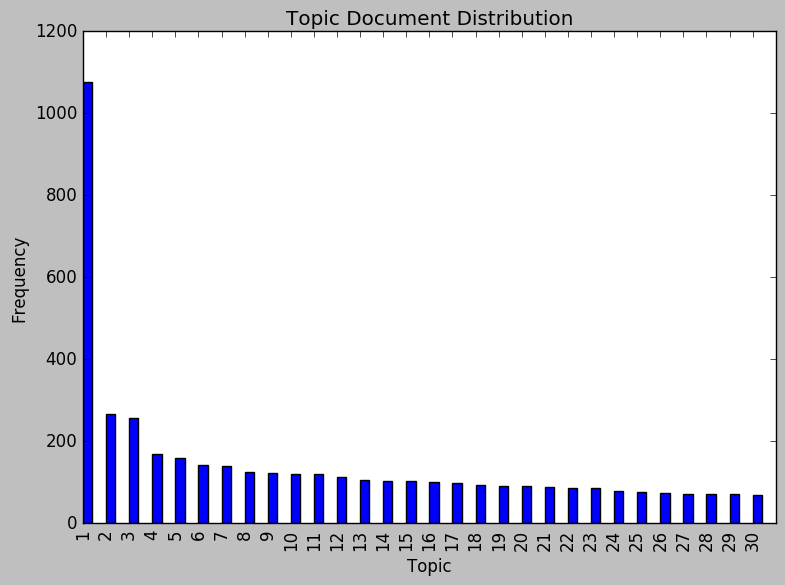

In [44]:
x_data = []
y_data = []
for key, value in sorted(km_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 30:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure()
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.tight_layout()
fig.savefig('tmp/size_chart_km.png')
plt.show()

In [45]:
np.average(y_data)

145.73333333333332

In [46]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    fig = plt.figure()
    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.tight_layout()
    plt.title("Probability Distribution of Topic Sizes - K-means")
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")
    fig.savefig('tmp/prob_chart_km.png')

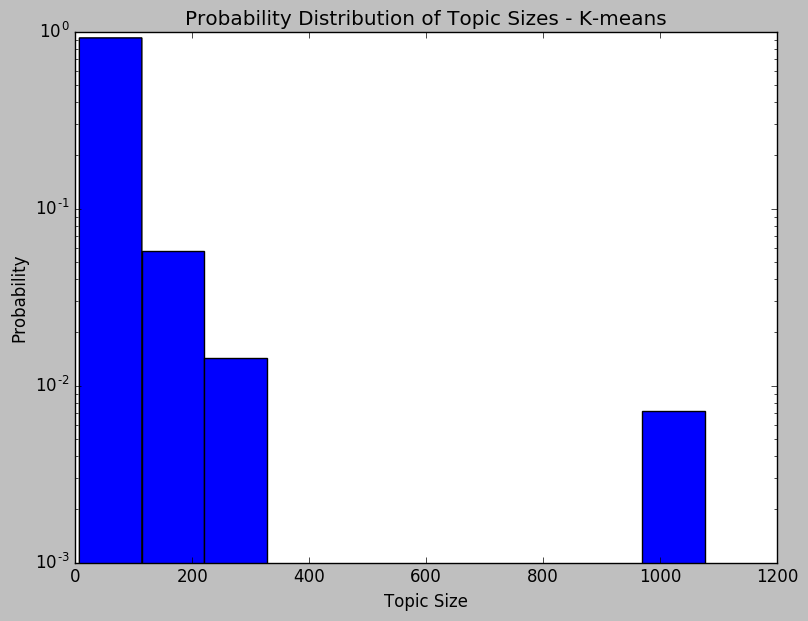

In [47]:
topics_to_prob_dist(km_topics)

In [48]:
km_tfidf_topics = {}

for k, vs in km_topics.items():
    km_tfidf_topics[k] = []
    for v in vs:
        km_tfidf_topics[k].append(docs[v]['tfidf'])

In [49]:
km_labels_true = {}

for k, vs in km_topics.items():
    km_labels_true[k] = []
    for v in vs:
        km_labels_true[k].append(docs[v]['section_id'])

In [50]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(km_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(km_tfidf_topics)))

Overall Similarity 0.237
Inter Cluster 0.113


In [160]:
print("Intra")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in km_tfidf_topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,141,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in km_tfidf_topics.items() if k <= i})), end=",")

Intra
0.110,0.151,0.158,0.156,0.160,0.170,0.181,0.184,0.186,0.189,0.196,0.201,0.211,0.228,
Inter
0.315,0.231,0.202,0.189,0.184,0.171,0.159,0.155,0.152,0.147,0.140,0.136,0.130,0.122,

In [139]:
sub_topics = {k: v for k, v in km_tfidf_topics.items() if k <= 101}
topic_centroids = cluster_centroids(sub_topics)
matx_c = scipy.sparse.vstack((topic_centroids.values()))
matx_c_c = cosine_similarity(matx_c)
matx_c_c.shape

(101, 101)

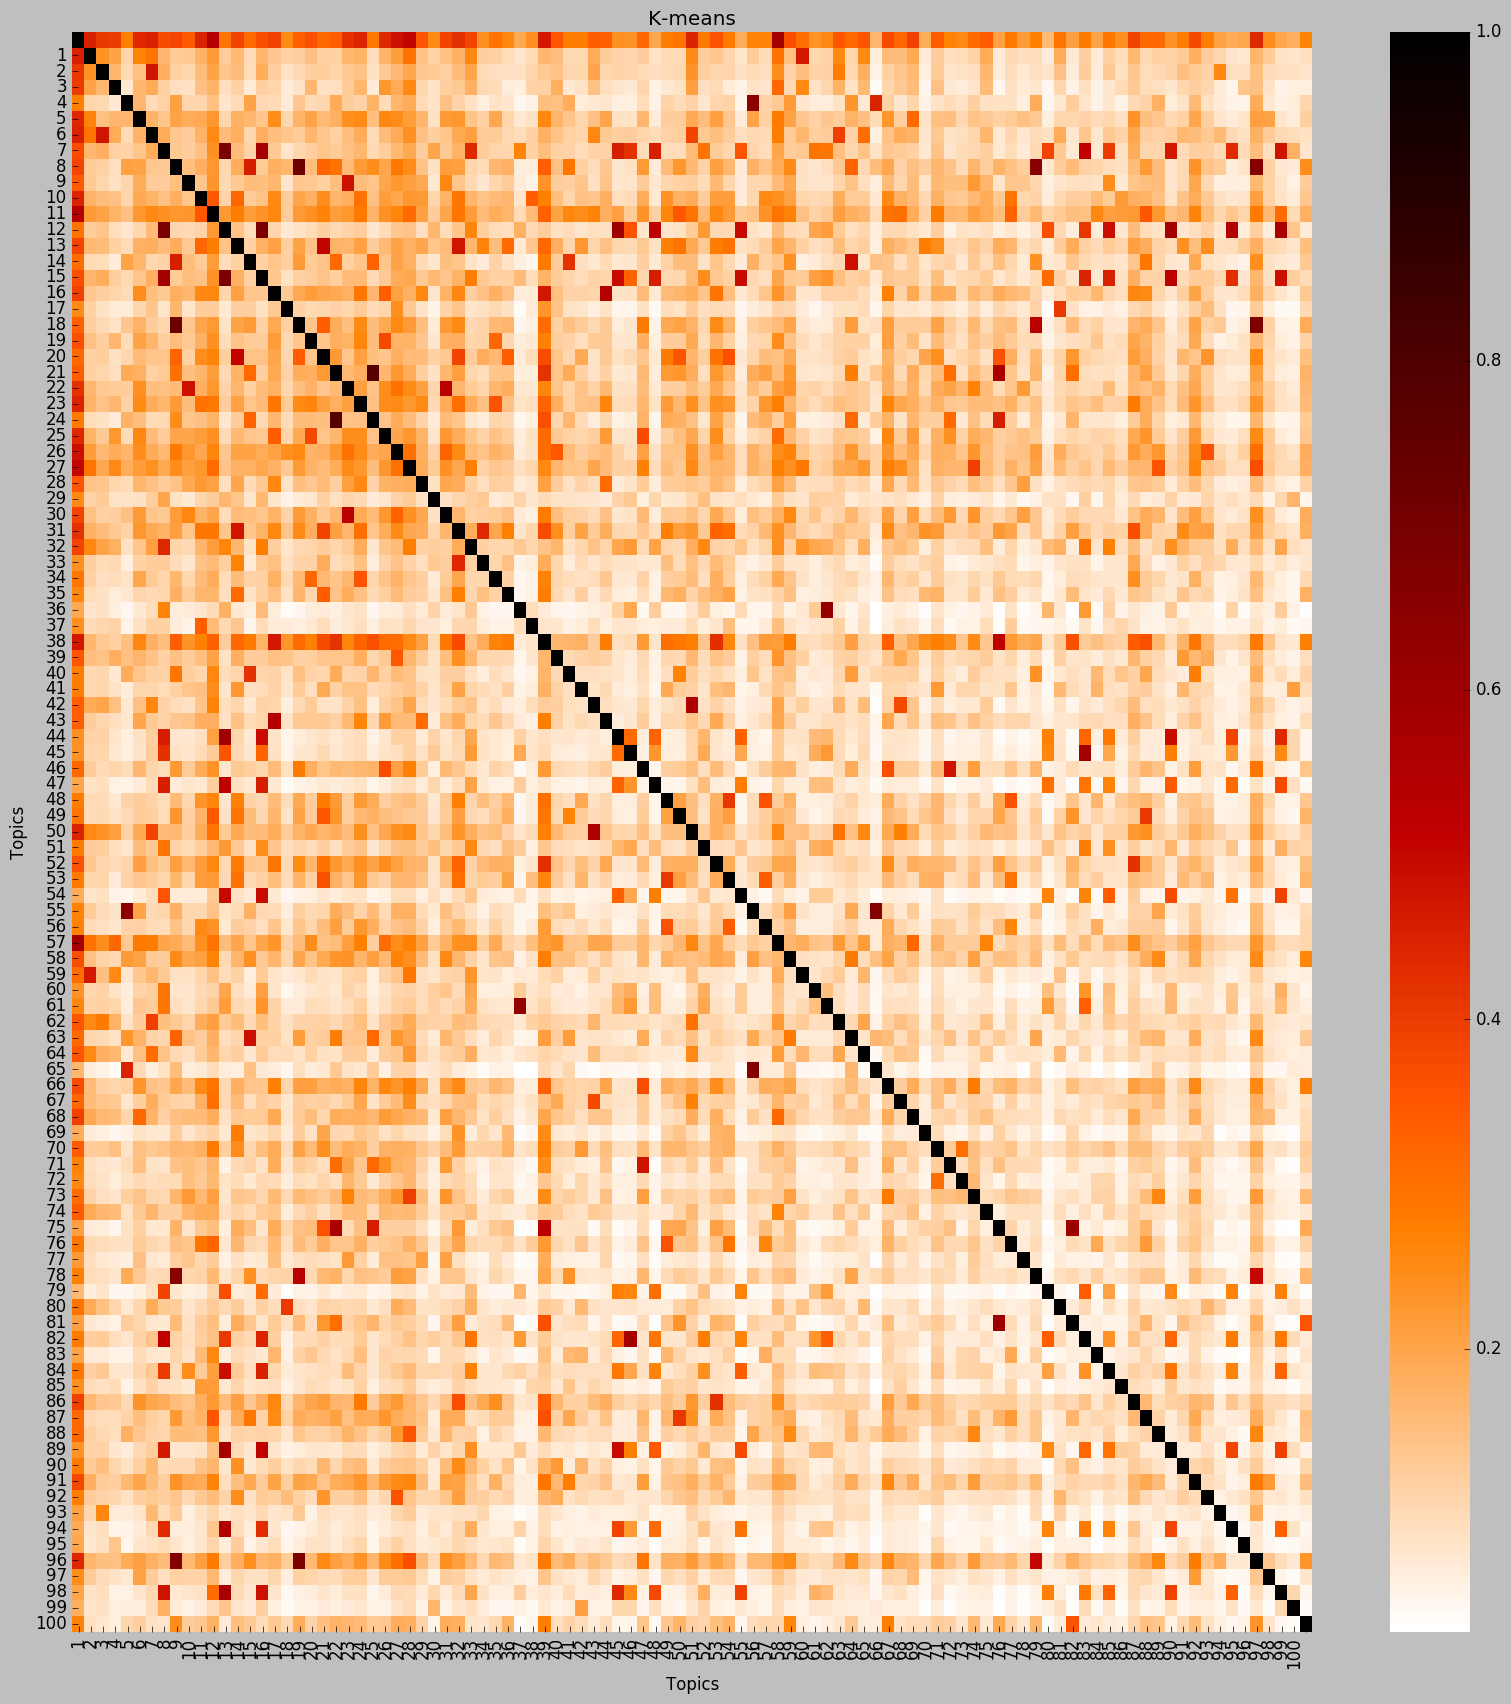

In [142]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 20))
sns_plt = sns.heatmap(matx_c_c, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,101), yticklabels=(-np.sort(-np.arange(1,101))))
# sns_plt.invert_yaxis()
plt.title("K-means")
plt.xlabel("Topics")
plt.ylabel("Topics")